Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4297 entries, 0 to 4296
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SettlementValue           4297 non-null   float64
 1   AccidentType              4226 non-null   object 
 2   InjuryPrognosis           4297 non-null   int64  
 3   SpecialHealthExpenses     4297 non-null   float64
 4   SpecialReduction          4297 non-null   float64
 5   SpecialOverage            4297 non-null   float64
 6   GeneralRest               4297 non-null   float64
 7   SpecialAdditionalInjury   4297 non-null   float64
 8   SpecialEarningsLoss       4297 non-null   float64
 9   SpecialUsageLoss          4297 non-null   float64
 10  SpecialMedications        4297 non-null   float64
 11  SpecialAssetDamage        4297 non-null   float64
 12  SpecialRehabilitation     4297 non-null   float64
 13  SpecialFixes              4297 non-null   flo

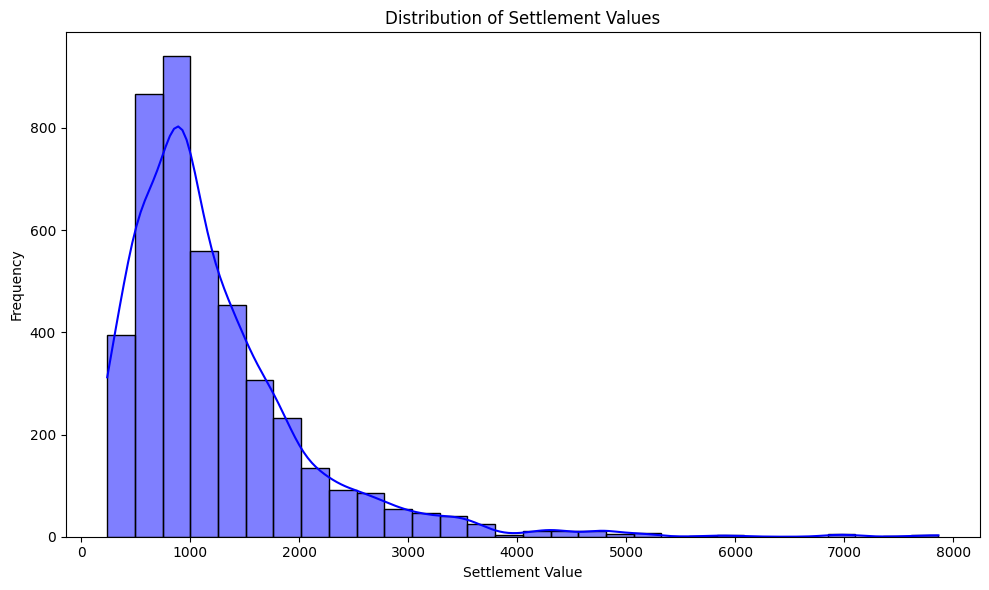

In [1]:
# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


# Load the processed claim data
data_path = 'ProcessedClaimData.csv' 
claim_data = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset Overview:")
print(claim_data.info())
print("\nFirst 5 rows of the dataset:")
print(claim_data.head())

# Check for missing values
missing_values = claim_data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

# Basic statistics of numerical columns
print("\nBasic statistics of numerical columns:")
print(claim_data.describe())

# Visualize the distribution of the target variable
target_col = 'SettlementValue'
plt.figure(figsize=(10, 6))
sns.histplot(claim_data[target_col], kde=True, bins=30, color='blue')
plt.title('Distribution of Settlement Values')
plt.xlabel('Settlement Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Original Settlement Value statistics:
count    4297.000000
mean     1218.505187
std       858.286445
min       240.000000
25%       670.000000
50%       989.000000
75%      1515.000000
max      7862.900000
Name: SettlementValue, dtype: float64

Log-transformed Settlement Value statistics:
count    4297.000000
mean        6.900062
std         0.649392
min         5.484797
25%         6.508769
50%         6.897705
75%         7.323831
max         8.970038
Name: LogSettlementValue, dtype: float64


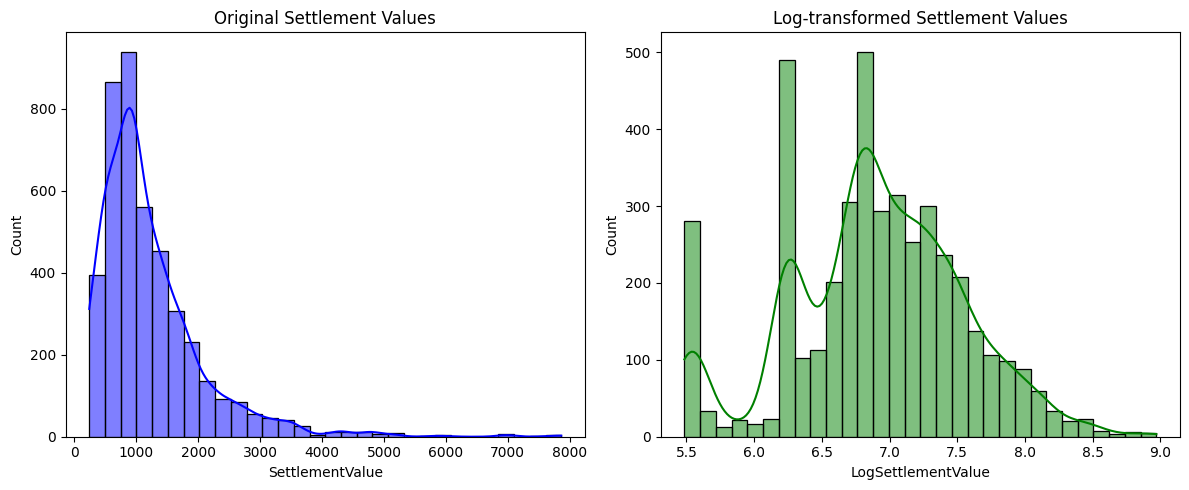

In [2]:
# Apply log transformation to the target variable
claim_data['LogSettlementValue'] = np.log1p(claim_data[target_col])
print("Original Settlement Value statistics:")
print(claim_data[target_col].describe())
print("\nLog-transformed Settlement Value statistics:")
print(claim_data['LogSettlementValue'].describe())

# Update target column to use log-transformed values
original_target_col = target_col
target_col = 'LogSettlementValue'

# Visualize the transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(claim_data[original_target_col], kde=True, bins=30, color='blue')
plt.title('Original Settlement Values')
plt.subplot(1, 2, 2)
sns.histplot(claim_data[target_col], kde=True, bins=30, color='green')
plt.title('Log-transformed Settlement Values')
plt.tight_layout()
plt.show()

In [3]:
# Function to identify categorical and numerical columns (same as model_comparison.ipynb)
def identify_columns(data):
    # Identify categorical and numerical columns
    categorical_cols = data.select_dtypes(include=['object', 'string']).columns.tolist()
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Remove the target variable from the feature lists
    target_col = 'LogSettlementValue'
    
    # Remove both the log-transformed target AND the original settlement value from features
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    if 'SettlementValue' in numerical_cols: 
        numerical_cols.remove('SettlementValue') 
    
    return categorical_cols, numerical_cols, target_col

# Define preprocessor function (similar to model_comparison.ipynb)
def define_preprocessor(data):
    categorical_cols, numerical_cols, _ = identify_columns(data)
    
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle missing numerical values with median
        ('scaler', StandardScaler())                    # Standardize numerical features
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    return preprocessor, numerical_cols, categorical_cols

# Get categorical and numerical columns
categorical_cols, numerical_cols, target_col = identify_columns(claim_data)
print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")
print(f"Target column: {target_col}")


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent']
Target column: LogSettlementValue


# Feature Selection Pipeline: XGBoost vs Random Forest
This section implements a pipeline to compare XGBoost and Random Forest for feature selection, then selects the better performing model for determining the top 10 features.

Start comparing feature selection models...

1. Training and evaluating Random Forest model...
Random Forest MSE: 0.0342 (±0.0063)
Random Forest training time: 14.12 seconds

2. Training and evaluating XGBoost model...
XGBoost MSE: 0.0318 (±0.0044)
XGBoost training time: 0.35 seconds

3. Comparing models:
           Model       MSE       Std  Training Time (s)
0  Random Forest  0.034198  0.006271          14.115039
1        XGBoost  0.031754  0.004385           0.346921

Best model for feature selection: XGBoost


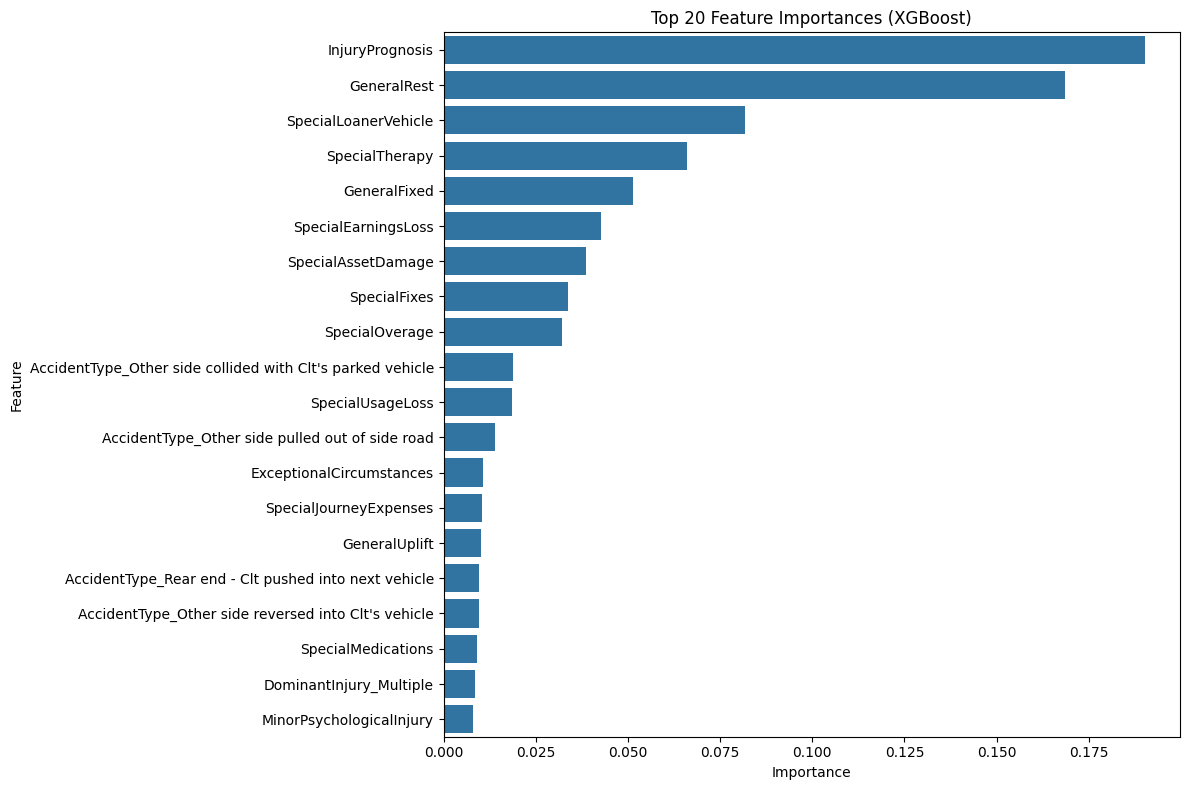


Selected top 10 features using XGBoost:
['InjuryPrognosis' 'GeneralRest' 'SpecialLoanerVehicle' 'SpecialTherapy'
 'GeneralFixed' 'SpecialEarningsLoss' 'SpecialAssetDamage' 'SpecialFixes'
 'SpecialOverage'
 "AccidentType_Other side collided with Clt's parked vehicle"]

Number of common features in top 20: 14 out of 20
Common features: {'SpecialTherapy', 'MinorPsychologicalInjury', 'SpecialJourneyExpenses', 'SpecialAssetDamage', 'SpecialLoanerVehicle', 'SpecialFixes', 'AccidentType_Other side pulled out of side road', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'InjuryPrognosis', 'SpecialOverage', 'GeneralRest', 'GeneralFixed', 'GeneralUplift'}


In [4]:
# Prepare data for the feature selection models
X = claim_data.drop(columns=[target_col, 'SettlementValue'])
y = claim_data[target_col].values

# Create and fit the preprocessor for features
preprocessor, numerical_cols, categorical_cols = define_preprocessor(claim_data)
X_processed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
feature_names = []
feature_names.extend(numerical_cols)
if categorical_cols:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    feature_names.extend(cat_feature_names)

print("Start comparing feature selection models...")

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 1. Train and evaluate Random Forest
print("\n1. Training and evaluating Random Forest model...")
import time
start_time_rf = time.time()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Cross-validation for Random Forest
rf_scores = cross_val_score(rf_model, X_processed, y, cv=cv, scoring='neg_mean_squared_error')
rf_mse = -rf_scores.mean()
rf_std = rf_scores.std()

# Fit Random Forest on the full dataset for feature importance
rf_model.fit(X_processed, y)
rf_importances = rf_model.feature_importances_
end_time_rf = time.time()
rf_time = end_time_rf - start_time_rf

# Create a DataFrame for Random Forest feature importances
rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

print(f"Random Forest MSE: {rf_mse:.4f} (±{rf_std:.4f})")
print(f"Random Forest training time: {rf_time:.2f} seconds")

# 2. Train and evaluate XGBoost
print("\n2. Training and evaluating XGBoost model...")
start_time_xgb = time.time()
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Cross-validation for XGBoost
xgb_scores = cross_val_score(xgb_model, X_processed, y, cv=cv, scoring='neg_mean_squared_error')
xgb_mse = -xgb_scores.mean()
xgb_std = xgb_scores.std()

# Fit XGBoost on the full dataset for feature importance
xgb_model.fit(X_processed, y)
xgb_importances = xgb_model.feature_importances_
end_time_xgb = time.time()
xgb_time = end_time_xgb - start_time_xgb

# Create a DataFrame for XGBoost feature importances
xgb_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values('Importance', ascending=False)

print(f"XGBoost MSE: {xgb_mse:.4f} (±{xgb_std:.4f})")
print(f"XGBoost training time: {xgb_time:.2f} seconds")

# 3. Compare the models and select the better one
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'MSE': [rf_mse, xgb_mse],
    'Std': [rf_std, xgb_std],
    'Training Time (s)': [rf_time, xgb_time]
})
print("\n3. Comparing models:")
print(model_comparison)

# Determine the better model based on MSE
best_model_name = model_comparison.loc[model_comparison['MSE'].idxmin(), 'Model']
print(f"\nBest model for feature selection: {best_model_name}")

# Select the feature importance from the better model
if best_model_name == 'Random Forest':
    best_feature_importance = rf_feature_importance
    model_name_short = 'RF'
else:
    best_feature_importance = xgb_feature_importance
    model_name_short = 'XGB'

# Visualize the top 20 features from the better model
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=best_feature_importance.head(20))
plt.title(f'Top 20 Feature Importances ({best_model_name})')
plt.tight_layout()
plt.show()

# Select the top 10 features from the better model
top_10_features = best_feature_importance.head(10)['Feature'].values
print(f"\nSelected top 10 features using {best_model_name}:")
print(top_10_features)

# Compare feature rankings between the two models
# Get top 20 features from each model
rf_top20 = rf_feature_importance.head(20)['Feature'].tolist()
xgb_top20 = xgb_feature_importance.head(20)['Feature'].tolist()

# Count features in both lists (common features)
common_features = set(rf_top20).intersection(set(xgb_top20))
print(f"\nNumber of common features in top 20: {len(common_features)} out of 20")
print("Common features:", common_features)

# Get the indices of the top 10 features in the processed data
top_10_indices = [i for i, feature in enumerate(feature_names) if feature in top_10_features]

# Save the feature selection results
feature_selection_results = {
    'best_model': best_model_name,
    'rf_mse': rf_mse,
    'xgb_mse': xgb_mse,
    'top_10_features': top_10_features.tolist(),
    'top_10_indices': top_10_indices,
    'common_features_in_top20': list(common_features)
}

# Prepare Data for PyTorch
Now that we have identified the top 10 features, we'll split the data into training, validation, and test sets and prepare it for neural network training.

In [5]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Apply preprocessing to the data
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Filter to include only the top 10 features selected by the best model
X_train_processed_top10 = X_train_processed[:, top_10_indices]
X_val_processed_top10 = X_val_processed[:, top_10_indices]
X_test_processed_top10 = X_test_processed[:, top_10_indices]

# Convert to PyTorch tensors using the selected top 10 features
X_train_tensor = torch.tensor(X_train_processed_top10, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_processed_top10, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_processed_top10, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoader objects for PyTorch
from torch.utils.data import DataLoader, TensorDataset
batch_size = 48
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes and shapes with top 10 features
print(f"\nTraining set size: {len(train_dataset)} samples, Features shape (top 10): {X_train_processed_top10.shape}")
print(f"Validation set size: {len(val_dataset)} samples, Features shape (top 10): {X_val_processed_top10.shape}")
print(f"Test set size: {len(test_dataset)} samples, Features shape (top 10): {X_test_processed_top10.shape}")


Training set size: 2577 samples, Features shape (top 10): (2577, 10)
Validation set size: 860 samples, Features shape (top 10): (860, 10)
Test set size: 860 samples, Features shape (top 10): (860, 10)


# Build and Train Neural Network Model
Implement a PyTorch neural network model for regression using the top 10 features with early stopping.

In [6]:

class OutlierLoss(nn.Module):
    def __init__(self, outlier_threshold=3.0, high_value_threshold=5000):
        super(OutlierLoss, self).__init__()
        self.outlier_threshold = outlier_threshold
        self.high_value_threshold = high_value_threshold
        
    def forward(self, predictions, targets):
        # Basic squared error
        squared_errors = (targets - predictions).pow(2)
        
        # Identify high-value claims (in log space)
        high_value_mask = targets > torch.log1p(torch.tensor(self.high_value_threshold).to(targets.device))
        
        # Apply adaptive weighting based on claim value
        weights = torch.ones_like(squared_errors)
        weights[high_value_mask] = 1.5  # Give more importance to high-value claims
        
        # Calculate percentage errors for large claims
        large_claim_mask = high_value_mask & (torch.abs(targets - predictions) / targets > 0.1)
        if large_claim_mask.sum() > 0:
            weights[large_claim_mask] = 2.0  # Further penalize large errors on high-value claims
            
        return (squared_errors * weights).mean()

def detect_outliers(data, threshold=3.0):
    """
    Simple outlier detection using z-score method.
    Returns a tensor mask where True indicates an outlier.
    """
    with torch.no_grad():
        # Compute z-scores
        mean = torch.mean(data)
        std = torch.std(data)
        z_scores = torch.abs((data - mean) / (std + 1e-8))
        
        # Create outlier mask where z-score exceeds threshold
        outlier_mask = z_scores > threshold
    
    return outlier_mask

class OutlierAwareLoss(nn.Module):
    def __init__(self, outlier_weight=0.6, threshold=2.5, relative_error_weight=0.4):  # Increased weights
        super(OutlierAwareLoss, self).__init__()
        self.outlier_weight = outlier_weight
        self.threshold = threshold
        self.relative_error_weight = relative_error_weight
        
    def forward(self, predictions, targets):
        # Calculate squared errors (MSE component)
        squared_errors = (targets - predictions).pow(2)
        
        # Add relative error component to better handle percentage errors
        abs_diff = torch.abs(targets - predictions)
        relative_errors = abs_diff / (torch.abs(targets) + 1e-8)
        
        # Progressive penalization - higher relative weight for higher values
        value_factor = torch.clamp(targets / 7.0, 0.8, 1.5)  # log space adjustment factor
        combined_errors = (1-self.relative_error_weight) * squared_errors + \
                          self.relative_error_weight * relative_errors * value_factor
        
        # Detect outliers in target values
        outlier_mask = detect_outliers(targets, self.threshold)
        
        # Assign weights - more balanced between outliers and normal values
        weights = torch.ones_like(squared_errors)
        weights[outlier_mask] = self.outlier_weight
        
        # Apply weights to combined errors
        weighted_errors = combined_errors * weights
        
        return weighted_errors.mean()

# Import for clustering
from sklearn.cluster import KMeans

from sklearn.cluster import KMeans
import numpy as np
import torch
import torch.nn as nn

class ClusterAwareLoss(nn.Module):
    def __init__(self, n_clusters=5, recompute_every=50, exp_base=1.5, focus_factor=0.05):
        super(ClusterAwareLoss, self).__init__()
        self.n_clusters = n_clusters
        self.kmeans = None
        self.cluster_weights = None
        self.recompute_every = recompute_every
        self.iter_count = 0
        self.initialized = False
        self.exp_base = exp_base  # Base for exponential weighting
        self.focus_factor = focus_factor  # Controls weight increase for difficult samples
        self.error_history = {}  # Track errors by sample index
        
    def _initialize_clusters(self, targets):
        # Move targets to CPU for scikit-learn
        targets_np = targets.detach().cpu().numpy().reshape(-1, 1)
        
        # Fit KMeans with more clusters for better granularity
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
        self.kmeans.fit(targets_np)
        
        # Determine cluster centers and set weights exponentially
        centers = self.kmeans.cluster_centers_.flatten()
        sorted_indices = np.argsort(centers)
        
        # Use exponential weighting for more aggressive focus on high-value clusters
        self.cluster_weights = {}
        for i, idx in enumerate(sorted_indices):
            weight = self.exp_base ** i  # Exponential scaling
            self.cluster_weights[idx] = weight
            
        # Store cluster centers for adaptive balance between errors
        self.cluster_centers = {idx: centers[idx] for idx in range(len(centers))}
        self.initialized = True
    
    def _adaptive_error_balance(self, cluster_id):
        """Return adaptive balance between squared and relative errors based on cluster value"""
        # Higher clusters (higher values) get more relative error weight
        relative_weight = min(0.8, 0.3 + (cluster_id / self.n_clusters) * 0.5)
        squared_weight = 1.0 - relative_weight
        return squared_weight, relative_weight
    
    def _detect_extreme_outliers(self, targets, predictions):
        """Identify extreme outliers that need special handling"""
        with torch.no_grad():
            # Calculate percent errors
            percent_errors = torch.abs((targets - predictions) / (targets + 1e-8))
            # Identify extreme outliers (errors > 50%)
            extreme_outliers = percent_errors > 0.5
        return extreme_outliers
        
    def forward(self, predictions, targets, batch_indices=None):
        # Initialize clusters on first call
        if not self.initialized:
            self._initialize_clusters(targets)
            
        # Periodically recompute clusters
        self.iter_count += 1
        if self.iter_count % self.recompute_every == 0:
            self._initialize_clusters(targets)
        
        # Get cluster assignments for the current batch
        targets_np = targets.detach().cpu().numpy().reshape(-1, 1)
        clusters = self.kmeans.predict(targets_np)
        
        # Calculate base errors
        squared_errors = (targets - predictions).pow(2)
        abs_diff = torch.abs(targets - predictions)
        relative_errors = abs_diff / (torch.abs(targets) + 1e-8)
        
        # Identify extreme outliers
        extreme_outliers = self._detect_extreme_outliers(targets, predictions)
        
        # Apply cluster-specific weights with adaptive error balancing
        weights = torch.ones_like(squared_errors)
        combined_errors = torch.zeros_like(squared_errors)
        
        for i in range(len(targets)):
            cluster_id = clusters[i]
            squared_weight, relative_weight = self._adaptive_error_balance(cluster_id)
            
            # Combine errors with cluster-specific balance
            combined_errors[i] = (squared_weight * squared_errors[i] + 
                                 relative_weight * relative_errors[i])
            
            # Apply cluster weight
            weights[i] = self.cluster_weights[cluster_id]
            
            # Extra weight for extreme outliers
            if extreme_outliers[i]:
                weights[i] *= 1.5
                
            # Apply value-based scaling - higher values get more weight
            value_scale = torch.log1p(targets[i]) / 5.0  # Normalized log scale
            weights[i] *= (1.0 + value_scale)
        
        # Apply weights to errors
        weighted_errors = combined_errors * weights
        
        return weighted_errors.mean()

Using device: mps


/Users/far/Desktop/desd/desd_1/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/160, Train Loss: 50.1420, Val Loss: 1.4948
  Found new best model with validation loss: 1.4948 (improved by 0.00%)
Epoch 2/160, Train Loss: 1.3826, Val Loss: 0.9127
  Found new best model with validation loss: 0.9127 (improved by 38.94%)
Epoch 3/160, Train Loss: 0.8587, Val Loss: 0.3074
  Found new best model with validation loss: 0.3074 (improved by 66.32%)
Epoch 4/160, Train Loss: 0.5905, Val Loss: 0.4887
Epoch 5/160, Train Loss: 0.5756, Val Loss: 0.2942
  Found new best model with validation loss: 0.2942 (improved by 4.28%)
Epoch 6/160, Train Loss: 0.4313, Val Loss: 0.4048
Epoch 7/160, Train Loss: 0.4201, Val Loss: 0.3315
Epoch 8/160, Train Loss: 0.4160, Val Loss: 0.4095
Epoch 9/160, Train Loss: 0.2983, Val Loss: 0.4435
Epoch 10/160, Train Loss: 0.3272, Val Loss: 0.2592
  Found new best model with validation loss: 0.2592 (improved by 11.90%)
Epoch 11/160, Train Loss: 0.2573, Val Loss: 0.3731
Epoch 12/160, Train Loss: 0.2896, Val Loss: 0.1994
  Found new best model with valid

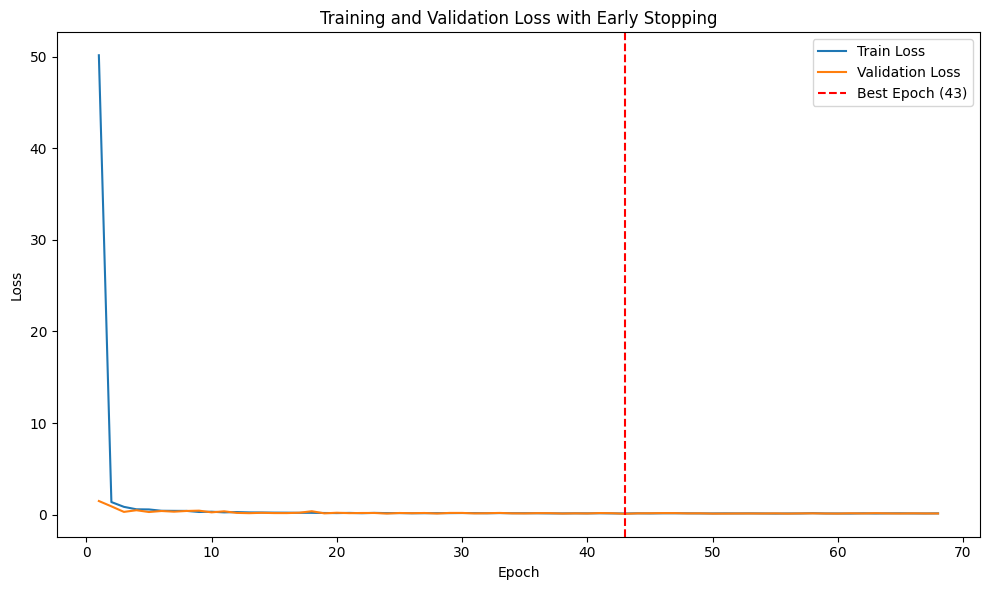

In [7]:
# Define the PyTorch neural network model for top 10 features
# More balanced neural network that avoids over-correction
# Check if MPS (Metal Performance Shaders) backend is available for Apple Silicon
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Neural network with slight improvements to capture high-value claims better
class InsuranceNN(nn.Module):
    def __init__(self, input_size):
        super(InsuranceNN, self).__init__()
        
        # Main network path
        self.input_layer = nn.Linear(input_size, 128)  # Wider first layer
        self.bn1 = nn.BatchNorm1d(128)
        self.hidden1 = nn.Linear(128, 96)
        self.bn2 = nn.BatchNorm1d(96)
        self.hidden2 = nn.Linear(96, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.hidden3 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        
        # Specialized branches with increased capacity for value ranges
        self.low_value_net = nn.Sequential(
            nn.Linear(32, 24),
            nn.LeakyReLU(0.1),
            nn.Linear(24, 16)
        )
        
        self.mid_value_net = nn.Sequential(
            nn.Linear(32, 32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(32, 16)
        )
        
        self.high_value_net = nn.Sequential(
            nn.Linear(32, 48),  # More capacity for high values
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(48, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 16)
        )
        
        # Shared features from main network
        self.shared_features = nn.Linear(32, 16)
        
        # Combine all branches plus original features for residual connection
        self.final = nn.Linear(input_size + 64, 1)
        
    def forward(self, x):
        # Main network with leaky ReLU and dropout
        h1 = nn.functional.leaky_relu(self.bn1(self.input_layer(x)), 0.1)
        h1 = nn.functional.dropout(h1, p=0.2, training=self.training)
        
        h2 = nn.functional.leaky_relu(self.bn2(self.hidden1(h1)), 0.1)
        h2 = nn.functional.dropout(h2, p=0.2, training=self.training)
        
        h3 = nn.functional.leaky_relu(self.bn3(self.hidden2(h2)), 0.1)
        h3 = nn.functional.dropout(h3, p=0.1, training=self.training)
        
        h4 = nn.functional.leaky_relu(self.bn4(self.hidden3(h3)), 0.1)
        
        # Branch networks
        low_features = self.low_value_net(h4)
        mid_features = self.mid_value_net(h4)
        high_features = self.high_value_net(h4)
        shared_features = self.shared_features(h4)
        
        # Combine features including original input (residual connection)
        combined = torch.cat([low_features, mid_features, high_features, shared_features, x], dim=1)
        return self.final(combined)
    
# Initialize the model
# Define the model with the same architecture (no changes needed)
input_size = X_train_tensor.shape[1]
model = InsuranceNN(input_size).to(device)

# Use the new cluster-aware loss function
criterion = ClusterAwareLoss(n_clusters=5, recompute_every=50, exp_base=1.5).to(device)

# Keep the same optimizer but slightly adjust learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=2e-5, betas=(0.9, 0.999))

# Use the same scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.7,
    patience=10,
    verbose=True,
    min_lr=1e-6
)

# Lower and more effective batch size for this dataset
batch_size = 24
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training settings
num_epochs = 160  # Slightly more epochs
early_stopping_patience = 25
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
best_epoch = 0

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Gentle gradient clipping 
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)
        
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Update learning rate
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic with best model tracking
    if val_loss < best_val_loss:
        improvement = (best_val_loss - val_loss) / best_val_loss * 100 if best_val_loss != float('inf') else 0
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  Found new best model with validation loss: {val_loss:.4f} (improved by {improvement:.2f}%)")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered. Best epoch was {best_epoch}")
            break

# Load the best model
print("\nLoading best model from checkpoint...")
model.load_state_dict(best_model_state)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss with Early Stopping")
plt.legend()
plt.tight_layout()
plt.show()

Test Loss (MSE in log space): 0.1445
Test R² (in log space): 0.8818


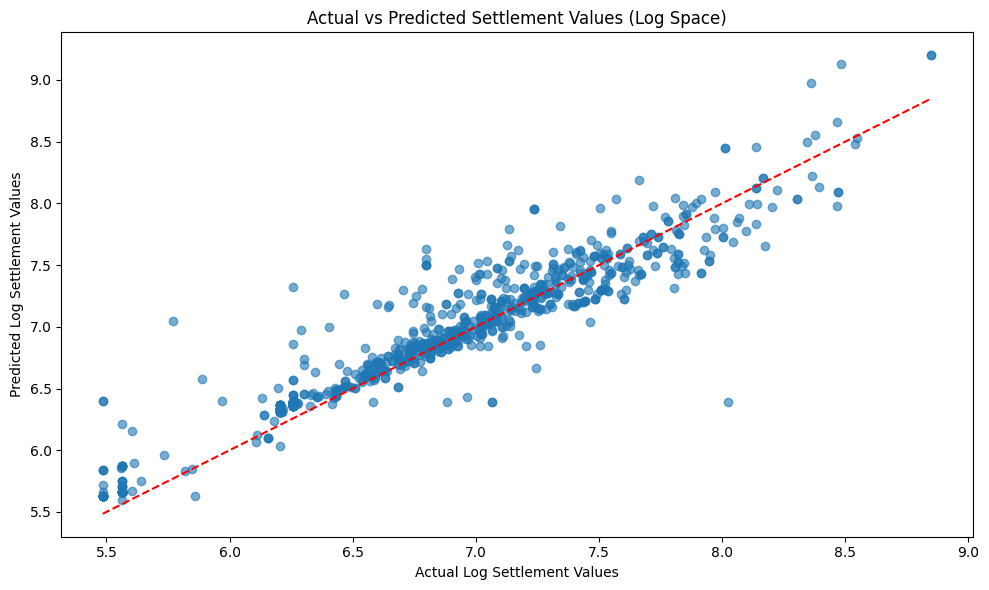

In [8]:
# Evaluate the model on the test set in log space
model.eval()
test_loss = 0.0
predictions_list = []
actuals_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item() * X_batch.size(0)

        predictions_list.extend(predictions.cpu().numpy())
        actuals_list.extend(y_batch.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_r2 = r2_score(actuals_list, predictions_list)
print(f"Test Loss (MSE in log space): {test_loss:.4f}")
print(f"Test R² (in log space): {test_r2:.4f}")


# Plot actual vs predicted values in log space
plt.figure(figsize=(10, 6))
plt.scatter(actuals_list, predictions_list, alpha=0.6)
plt.plot([min(actuals_list), max(actuals_list)], [min(actuals_list), max(actuals_list)], 'r--')
plt.xlabel("Actual Log Settlement Values")
plt.ylabel("Predicted Log Settlement Values")
plt.title("Actual vs Predicted Settlement Values (Log Space)")
plt.tight_layout()
plt.show()

Errors in GBP (£):
MSE: £170961.50
RMSE: £413.47
MAE: £206.46
MAPE: 16.37%
R²: 0.7607

Value range specific MAPE:
Low values (<£1000): 16.62%
Mid values (£1000-£3000): 15.06%
High values (>£3000): 28.30%


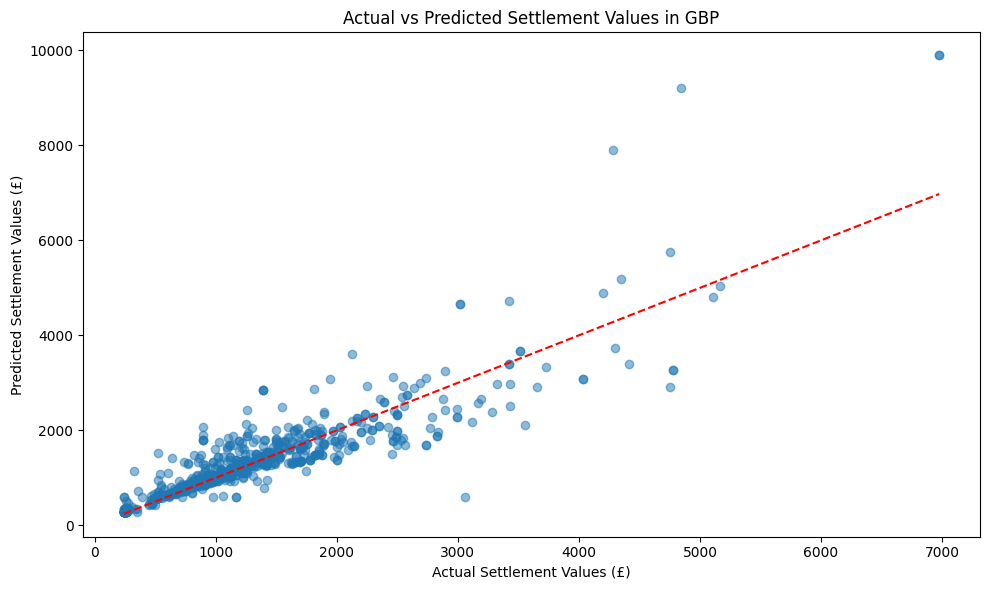

In [10]:
def evaluate_model_in_gbp(model, data_loader, device):
    """
    Enhanced evaluation function with value-range specific metrics
    """
    model.eval()
    actual_gbp = []
    predicted_gbp = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            predictions = model(X_batch)
            y_gbp = np.expm1(y_batch.cpu().numpy())
            pred_gbp = np.expm1(predictions.cpu().numpy())
    
            actual_gbp.extend(y_gbp)
            predicted_gbp.extend(pred_gbp)

    # Convert to arrays for easier manipulation
    actual_gbp = np.array(actual_gbp).flatten()
    predicted_gbp = np.array(predicted_gbp).flatten()
    
    # Calculate error metrics in GBP
    mse_gbp = mean_squared_error(actual_gbp, predicted_gbp)
    rmse_gbp = np.sqrt(mse_gbp)
    mae_gbp = mean_absolute_error(actual_gbp, predicted_gbp)
    mape_gbp = np.mean(np.abs((actual_gbp - predicted_gbp) / actual_gbp)) * 100
    r2_gbp = r2_score(actual_gbp, predicted_gbp)
    
    # Value range specific metrics
    low_values = actual_gbp < 1000
    mid_values = (actual_gbp >= 1000) & (actual_gbp < 3000)
    high_values = actual_gbp >= 3000
    
    low_mape = np.mean(np.abs((actual_gbp[low_values] - predicted_gbp[low_values]) / actual_gbp[low_values])) * 100 if any(low_values) else 0
    mid_mape = np.mean(np.abs((actual_gbp[mid_values] - predicted_gbp[mid_values]) / actual_gbp[mid_values])) * 100 if any(mid_values) else 0
    high_mape = np.mean(np.abs((actual_gbp[high_values] - predicted_gbp[high_values]) / actual_gbp[high_values])) * 100 if any(high_values) else 0
    
    print("Errors in GBP (£):")
    print(f"MSE: £{mse_gbp:.2f}")
    print(f"RMSE: £{rmse_gbp:.2f}")
    print(f"MAE: £{mae_gbp:.2f}")
    print(f"MAPE: {mape_gbp:.2f}%")
    print(f"R²: {r2_gbp:.4f}")
    print("\nValue range specific MAPE:")
    print(f"Low values (<£1000): {low_mape:.2f}%")
    print(f"Mid values (£1000-£3000): {mid_mape:.2f}%")
    print(f"High values (>£3000): {high_mape:.2f}%")
    
    return {
        'MSE_GBP': mse_gbp,
        'RMSE_GBP': rmse_gbp,
        'MAE_GBP': mae_gbp,
        'MAPE_GBP': mape_gbp,
        'R2_GBP': r2_gbp,
        'actual_gbp': actual_gbp,
        'predicted_gbp': predicted_gbp,
        'low_mape': low_mape,
        'mid_mape': mid_mape,
        'high_mape': high_mape
    }

# Call this function to evaluate on test set
gbp_metrics = evaluate_model_in_gbp(model, test_loader, device)

# Visualize predictions in GBP
plt.figure(figsize=(10, 6))
plt.scatter(gbp_metrics['actual_gbp'], gbp_metrics['predicted_gbp'], alpha=0.5)
plt.plot([min(gbp_metrics['actual_gbp']), max(gbp_metrics['actual_gbp'])], 
         [min(gbp_metrics['actual_gbp']), max(gbp_metrics['actual_gbp'])], 'r--')
plt.xlabel('Actual Settlement Values (£)')
plt.ylabel('Predicted Settlement Values (£)')
plt.title('Actual vs Predicted Settlement Values in GBP')
plt.tight_layout()
plt.show()

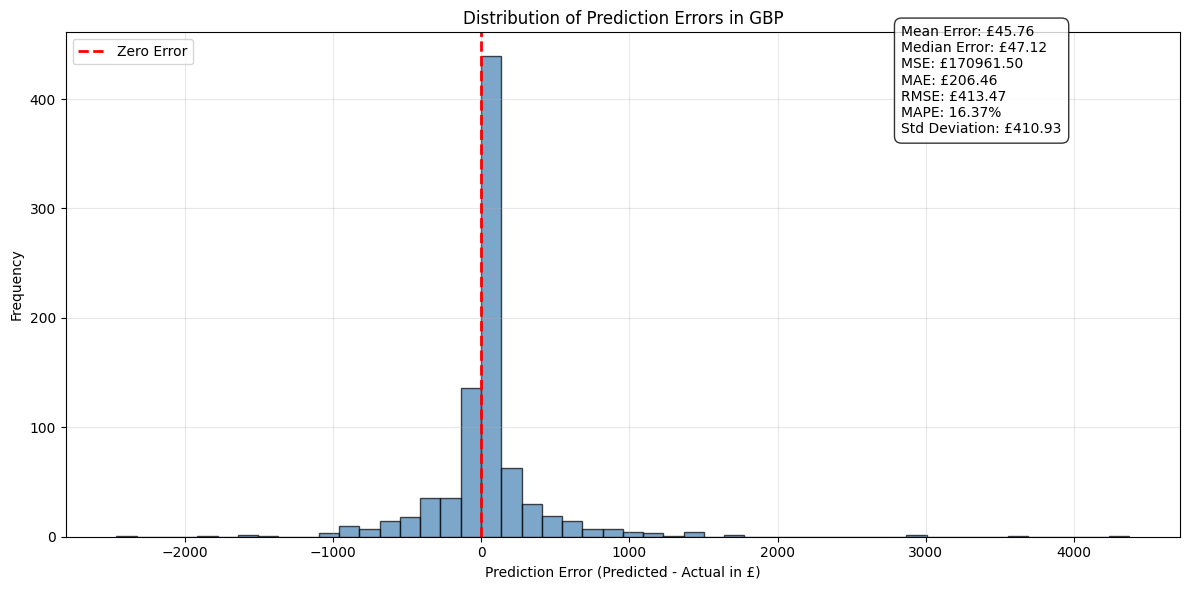

Error Analysis Complete!
Mean Absolute Error (MAE): £206.46
Root Mean Squared Error (RMSE): £413.47
Mean Absolute Percentage Error (MAPE): 16.37%


In [11]:
def analyze_prediction_errors_gbp(actual_gbp, predicted_gbp, figsize=(12, 6), bins=50, 
                                  color='steelblue', show_plot=True, save_path=None):
    """
    Analyze and visualize the errors between predicted and actual values in GBP (pounds).
    
    Parameters:
    -----------
    actual_gbp : array-like
        Actual settlement values in GBP
    predicted_gbp : array-like
        Predicted settlement values in GBP
    figsize : tuple, optional
        Figure size (width, height) in inches
    bins : int, optional
        Number of histogram bins
    color : str, optional
        Color for the histogram bars
    show_plot : bool, optional
        Whether to display the plot
    save_path : str, optional
        Path to save the figure (if None, figure is not saved)
        
    Returns:
    --------
    dict
        Dictionary containing error metrics (mean, median, std, MAE, RMSE)
    """
    # Convert inputs to numpy arrays if they aren't already
    actual_gbp = np.array(actual_gbp).flatten()
    predicted_gbp = np.array(predicted_gbp).flatten()
    
    # Calculate differences
    differences_gbp = predicted_gbp - actual_gbp
    
    # Calculate statistics
    mean_error = np.mean(differences_gbp)
    median_error = np.median(differences_gbp)
    std_error = np.std(differences_gbp)
    mae = np.mean(np.abs(differences_gbp))
    mse = np.mean(np.square(differences_gbp))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(differences_gbp / actual_gbp)) * 100
    
    # Create a histogram of the differences
    plt.figure(figsize=figsize)
    plt.hist(differences_gbp, bins=bins, alpha=0.7, color=color, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    
    # Add labels and title
    plt.xlabel('Prediction Error (Predicted - Actual in £)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors in GBP')
    
    # Add statistics to the plot
    stats_text = (f'Mean Error: £{mean_error:.2f}\n'
                  f'Median Error: £{median_error:.2f}\n'
                  f'MSE: £{mse:.2f}\n'
                  f'MAE: £{mae:.2f}\n'
                  f'RMSE: £{rmse:.2f}\n'
                  f'MAPE: {mape:.2f}%\n'
                  f'Std Deviation: £{std_error:.2f}')
    
    plt.annotate(stats_text, xy=(0.75, 0.8), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))
    
    plt.legend()
    plt.tight_layout()
    plt.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    if show_plot:
        plt.show()
    else:
        plt.close()
    
    # Return error metrics as a dictionary
    return {
        'mean_error': mean_error,
        'median_error': median_error,
        'std_error': std_error,
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

# Example usage - add this after evaluating your model with the evaluate_model_in_gbp function
error_metrics = analyze_prediction_errors_gbp(
    gbp_metrics['actual_gbp'], 
    gbp_metrics['predicted_gbp']
)

print("Error Analysis Complete!")
print(f"Mean Absolute Error (MAE): £{error_metrics['mae']:.2f}")
print(f"Root Mean Squared Error (RMSE): £{error_metrics['rmse']:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {error_metrics['mape']:.2f}%")

# Save Final Model

In [13]:
# # Save the model and related information
torch.save({
    'model_state_dict': model.state_dict(),
    'top_10_features': top_10_features,
    'feature_importance': best_feature_importance.head(10).to_dict('records'),
    'best_feature_selection_model': best_model_name,
    'input_size': input_size,
    'performance_metrics': {
        'mse_log': test_loss,
        'r2_log': test_r2,
        'mae_gbp': gbp_metrics['MAE_GBP'],
        'rmse_gbp': gbp_metrics['RMSE_GBP'],
        'mape_gbp': gbp_metrics['MAPE_GBP'],
        'r2_gbp': gbp_metrics['R2_GBP']
    }
}, 'neural_network_top10_features.pth')

# print("Model trained on top 10 features saved to 'neural_network_top10_features.pth'")